# 12_nndl_cv_mlp2

We will experiment with Neural Networks and Deep Learning on the no_na dataset. This is mlp2, our second version of multi-layer perceptron 

# Difference from mlp1 - no dropout on the input layer

In [ ]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

''' preprocessing '''
from sklearn.preprocessing import StandardScaler

In [ ]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [ ]:
# load data
train = pd.read_csv(root_dir/"data/train_no_na.csv")
test = pd.read_csv(root_dir/"data/test_no_na.csv")
print("data loaded")

data loaded


In [ ]:
# check shape
print(train.shape)
print(test.shape)

(279331, 138)
(120163, 138)


In [ ]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


# Helper functions

In [ ]:
# constants
SEED = 42

# cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=SEED, shuffle=True)

In [ ]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [ ]:
def model_scores(model, test, x_test, y_test):
  y_pred = model.predict(x_test) 
  y_pred = (y_pred > 0.5).astype(int)
  
  # # get some scores from helpers
  utility = utility_score(test, y_pred)
  accuracy =  accuracy_score(y_test, y_pred)

  # # confusion matrix
  # print("confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  true_pos = cm[1][1]
  true_neg = cm[0][0]
  false_pos = cm[0][1]
  false_neg = cm[1][0]

  # # plot confusion matrix
  # fig, ax = plt.subplots(figsize=(3, 3))
  # ax.imshow(cm)
  # ax.grid(False)
  # ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  # ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  # ax.set_ylim(1.5, -0.5)
  # for i in range(2):
  #     for j in range(2):
  #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  # plt.show()  

  # # AUC-ROC
  # print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, y_pred)

  # # plot auc-roc
  # fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  # plt.figure()
  # plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  # plt.plot([0, 1], [0, 1],'r--')
  # plt.xlim([0.0, 1.0])
  # plt.ylim([0.0, 1.05])
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('Receiver operating characteristic')
  # plt.legend(loc="lower right")
  # plt.show()

  return utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg

In [ ]:
import datetime
import csv

def save_scores(output_filename, workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg):
  # create output file if not exists
  try:
    f = open(root_dir/output_filename)
  except IOError:
    with open (root_dir/output_filename, 'a') as csvfile:
      headers = ["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"]
      writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n',fieldnames=headers)
      writer.writeheader() 
      print("created output file")  
    csvfile.close()

  # output file exists, append
  timestamp = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  
  ''' create another df that looks just like the excel file and concat with ''' 
  new_scores = pd.DataFrame(np.array([[workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg, timestamp]]),
                   columns=["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"],
                  )

  new_scores.to_csv(root_dir/output_filename, mode='a', header=False, index=False)
  print("saved model metrics")

In [ ]:
'''
used to generate the PosixPath variables for the results to save
'''
def results_paths(root_dir=root_dir):
    PATH_RESULTS = root_dir /'results_nndl'
    PATH_HISTORIES = PATH_RESULTS / 'histories'
    PATH_FIGURES = PATH_RESULTS / 'figures'
    PATH_CHECKPOINTS = PATH_RESULTS / 'checkpoints'
    PATH_PREDICTIONS = PATH_RESULTS / 'predictions'

    return PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS


''' 
used to save the history of a model as a npy file
'''
# filename like 'history/model_name.npy'
def history_saver(history, model_name, history_save_path, already_npy=False):
  history_json = {}

  if already_npy:
    history_npy = history
  else:
    history_npy = history.history

  np.save(history_save_path/model_name, history_npy)
  print("History saved")



''' 
used to load the history of a model from a npy file
'''
# filename like 'history/model_name.npy'
def history_loader(model_name, history_save_path):
  history_save_path = history_save_path/str(model_name+'.npy')
  history=np.load(history_save_path,allow_pickle='TRUE').item()
  print('History loaded')
  
  return history 

'''
used to plot the metrics for a given history
'''
def plot_metrics(history, model_name, figure_save_path):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # print(history.keys())

    # plot losses
    train_loss = history['loss']
    val_loss = history['val_loss']
    loss_title = 'loss against epochs'

    ax1.plot(train_loss, label='train')
    ax1.plot(val_loss, label='val')
    ax1.set_title(loss_title)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax1.legend()

    # plot accuracy_score
    accuracy_score = history['accuracy']
    val_accuracy_score = history['val_accuracy']
    accuracy_score_title = 'accuracy_score against epochs'

    ax2.plot(accuracy_score, label='train')
    ax2.plot(val_accuracy_score, label='val')
    ax2.set_title(accuracy_score_title)
    ax2.set_ylabel('accuracy_score')
    ax2.set_xlabel('epochs')
    ax2.legend()


    # plot accuracy_score
    auc_score = history['auc']
    val_auc_score = history['val_auc']
    auc_score_title = 'auc_score against epochs'

    ax3.plot(auc_score, label='train')
    ax3.plot(val_auc_score, label='val')
    ax3.set_title(auc_score_title)
    ax3.set_ylabel('auc_score')
    ax3.set_xlabel('epochs')
    ax3.legend()


    # save figure
    fig.suptitle('Metrics for model: ' + model_name)
    plt.savefig(figure_save_path/f'{model_name}.png')

    plt.show()  

# Neural Network - Model 2 (Dropout Rates)

In [ ]:
!pip install keras_tqdm

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from keras_tqdm import TQDMCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS = results_paths()

In [ ]:
def create_mlp(num_columns, hidden_units, activation, dropout_rates, learning_rate): 
  inp = Input(shape=(num_columns,))
  x = BatchNormalization()(inp)

  for i in range(len(hidden_units)):   
    x = Dense(hidden_units[i])(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[i])(x)

  x = Dense(1)(x)
  out = Activation("sigmoid")(x)

  model = Model(inputs=inp, outputs=out)

  model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(label_smoothing=1e-4),
    metrics=[BinaryAccuracy(name="accuracy"), AUC(name="auc")]
  )

  return model

In [ ]:
# settings to vary

# epochs default = [50] going forward for training due to time constraints, final evaluation put about 1000 to try and achieve convergence
epochs = [50] 

# batch_sizes default = [512] going forward for training due to time constraints, final evaluation can be batch size of 128/256 to achieve better utility scores
batch_sizes = [512]

# hidden_units default = [200, 400, 800, 400] going forward for training due to time constraints, final evaluation can be greater number of hidden units to achieve better utility scores
hidden_units = [
    [200, 400, 800, 400]
]

# dropout_rates should have same number of values as hidden_units
# dropout_rates default = [0.2, 0.2, 0.2, 0.2]
dropout_rates = [
    [0, 0, 0, 0],
    [0.2, 0.2, 0.2, 0.2],
    [0.4, 0.4, 0.4, 0.4]
] 

# activations default = [tf.keras.activations.relu]
activations = [tf.keras.activations.relu]

# learning_rates default = [1e-4]
learning_rates = [1e-4]


model_name:  mlp2_dropout_rates_[0, 0, 0, 0]
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function relu at 0x7f7e9f836cb0>, dropout_rate=[0, 0, 0, 0], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 8s 8ms/step - loss: 0.7360 - accuracy: 0.5237 - auc: 0.5336 - val_loss: 0.6886 - val_accuracy: 0.5513 - val_auc: 0.5740
Epoch 2/50
492/492 [==============================] - 3s 6ms/step - loss: 0.6746 - accuracy: 0.5752 - auc: 0.6082 - val_loss: 0.6829 - val_accuracy: 0.5586 - val_auc: 0.5883
Epoch 3/50
492/492 [==============================] - 3s 6ms/step - loss: 0.6604 - accuracy: 0.5955 - auc: 0.6384 - val_loss: 0.6808 - val_accuracy: 0.5689 - val_auc: 0.5989
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6522 - accuracy: 0.6082 - auc: 0.6558 - val_loss: 0.6758 - val_accuracy: 0.5723 - val_auc: 0.6075
Epoch 5/50
492/492 [==============================] - 3s 7ms/step -

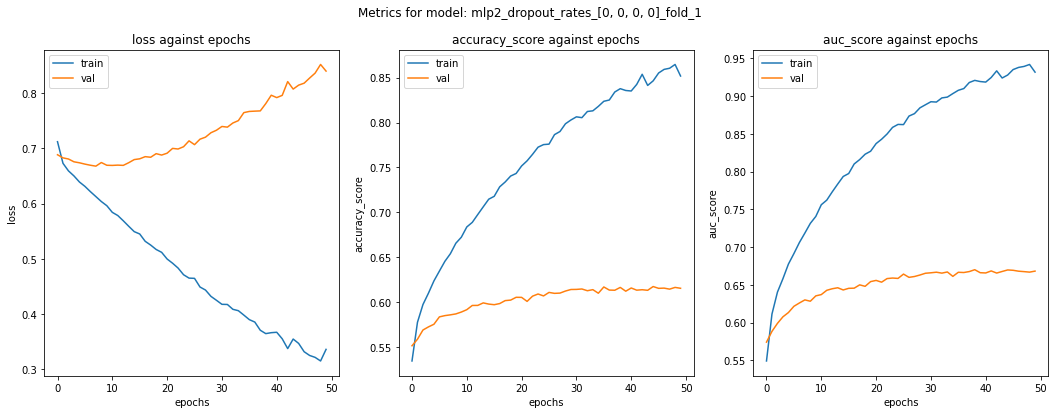

training model fold 2
Epoch 1/50
492/492 [==============================] - 5s 7ms/step - loss: 0.7408 - accuracy: 0.5228 - auc: 0.5352 - val_loss: 0.6952 - val_accuracy: 0.5416 - val_auc: 0.5650
Epoch 2/50
492/492 [==============================] - 3s 6ms/step - loss: 0.6762 - accuracy: 0.5736 - auc: 0.6055 - val_loss: 0.6849 - val_accuracy: 0.5578 - val_auc: 0.5869
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6610 - accuracy: 0.5938 - auc: 0.6362 - val_loss: 0.6768 - val_accuracy: 0.5692 - val_auc: 0.6024
Epoch 4/50
492/492 [==============================] - 3s 6ms/step - loss: 0.6492 - accuracy: 0.6105 - auc: 0.6591 - val_loss: 0.6753 - val_accuracy: 0.5728 - val_auc: 0.6098
Epoch 5/50
492/492 [==============================] - 3s 6ms/step - loss: 0.6378 - accuracy: 0.6261 - auc: 0.6798 - val_loss: 0.6711 - val_accuracy: 0.5805 - val_auc: 0.6181
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6295 - accuracy: 0.6354 - auc: 0

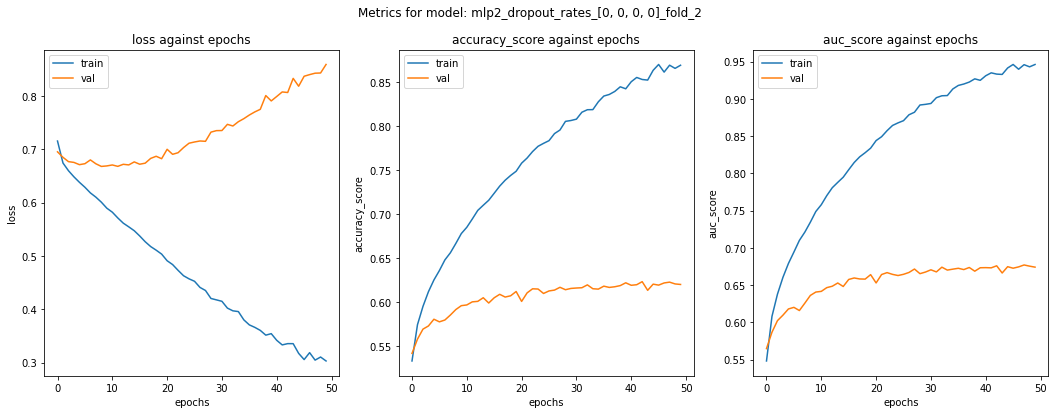

training model fold 3
Epoch 1/50
492/492 [==============================] - 5s 7ms/step - loss: 0.7418 - accuracy: 0.5234 - auc: 0.5322 - val_loss: 0.6995 - val_accuracy: 0.5412 - val_auc: 0.5632
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6762 - accuracy: 0.5715 - auc: 0.6046 - val_loss: 0.6841 - val_accuracy: 0.5587 - val_auc: 0.5888
Epoch 3/50
492/492 [==============================] - 3s 6ms/step - loss: 0.6584 - accuracy: 0.5965 - auc: 0.6407 - val_loss: 0.6811 - val_accuracy: 0.5674 - val_auc: 0.5986
Epoch 4/50
492/492 [==============================] - 3s 6ms/step - loss: 0.6492 - accuracy: 0.6106 - auc: 0.6591 - val_loss: 0.6753 - val_accuracy: 0.5739 - val_auc: 0.6104
Epoch 5/50
492/492 [==============================] - 3s 6ms/step - loss: 0.6378 - accuracy: 0.6254 - auc: 0.6797 - val_loss: 0.6733 - val_accuracy: 0.5771 - val_auc: 0.6174
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6281 - accuracy: 0.6383 - auc: 0

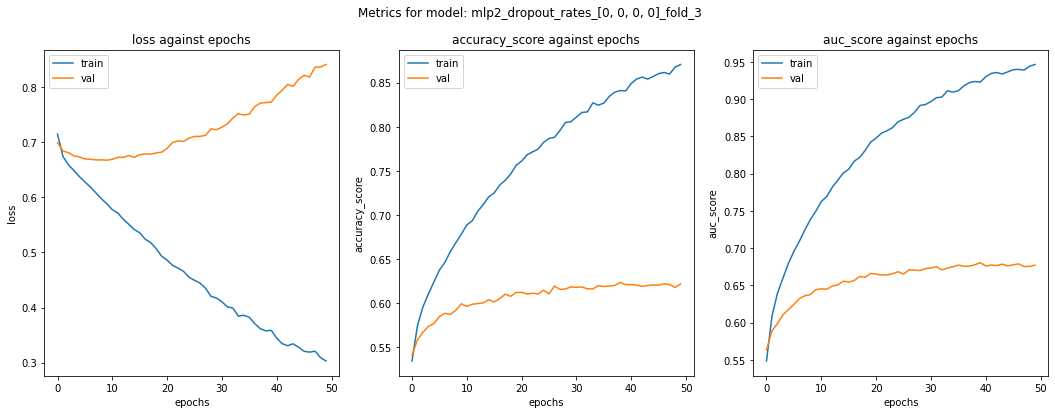

training model fold 4
Epoch 1/50
492/492 [==============================] - 5s 7ms/step - loss: 0.7380 - accuracy: 0.5230 - auc: 0.5315 - val_loss: 0.6932 - val_accuracy: 0.5497 - val_auc: 0.5712
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6758 - accuracy: 0.5711 - auc: 0.6040 - val_loss: 0.6782 - val_accuracy: 0.5623 - val_auc: 0.5960
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6613 - accuracy: 0.5925 - auc: 0.6352 - val_loss: 0.6737 - val_accuracy: 0.5728 - val_auc: 0.6086
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6488 - accuracy: 0.6103 - auc: 0.6591 - val_loss: 0.6764 - val_accuracy: 0.5733 - val_auc: 0.6077
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6410 - accuracy: 0.6204 - auc: 0.6734 - val_loss: 0.6703 - val_accuracy: 0.5819 - val_auc: 0.6215
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6291 - accuracy: 0.6346 - auc: 0

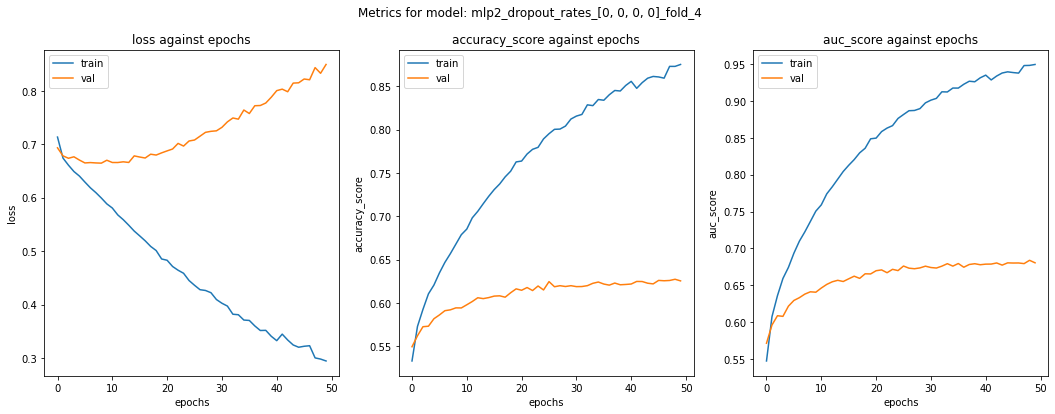

training model fold 5
Epoch 1/50
492/492 [==============================] - 5s 7ms/step - loss: 0.7384 - accuracy: 0.5240 - auc: 0.5334 - val_loss: 0.6898 - val_accuracy: 0.5532 - val_auc: 0.5764
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6756 - accuracy: 0.5741 - auc: 0.6076 - val_loss: 0.6821 - val_accuracy: 0.5617 - val_auc: 0.5893
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6611 - accuracy: 0.5924 - auc: 0.6358 - val_loss: 0.6748 - val_accuracy: 0.5672 - val_auc: 0.6040
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6493 - accuracy: 0.6103 - auc: 0.6589 - val_loss: 0.6767 - val_accuracy: 0.5707 - val_auc: 0.6072
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6402 - accuracy: 0.6222 - auc: 0.6757 - val_loss: 0.6684 - val_accuracy: 0.5805 - val_auc: 0.6219
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6290 - accuracy: 0.6365 - auc: 0

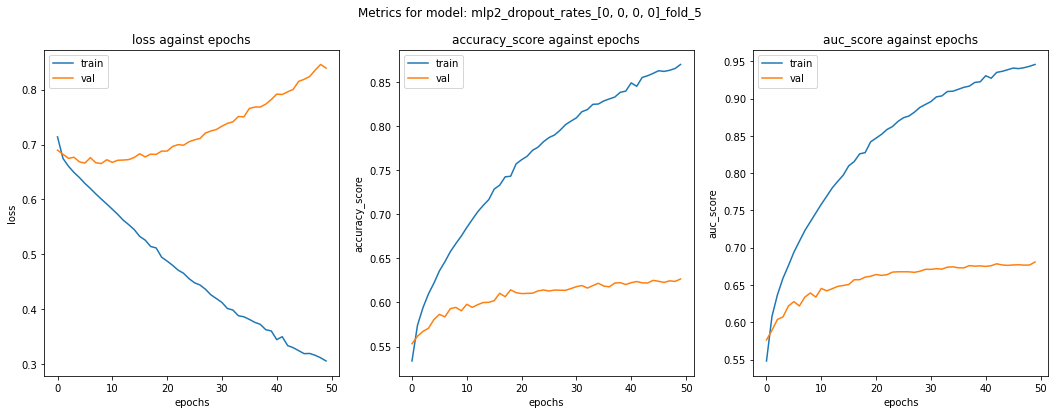

training model fold 6
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.7348 - accuracy: 0.5235 - auc: 0.5341 - val_loss: 0.6919 - val_accuracy: 0.5486 - val_auc: 0.5708
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6750 - accuracy: 0.5749 - auc: 0.6073 - val_loss: 0.6828 - val_accuracy: 0.5600 - val_auc: 0.5895
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6608 - accuracy: 0.5926 - auc: 0.6356 - val_loss: 0.6811 - val_accuracy: 0.5663 - val_auc: 0.5992
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6506 - accuracy: 0.6081 - auc: 0.6570 - val_loss: 0.6759 - val_accuracy: 0.5750 - val_auc: 0.6080
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6406 - accuracy: 0.6219 - auc: 0.6750 - val_loss: 0.6696 - val_accuracy: 0.5833 - val_auc: 0.6207
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6306 - accuracy: 0.6333 - auc: 0

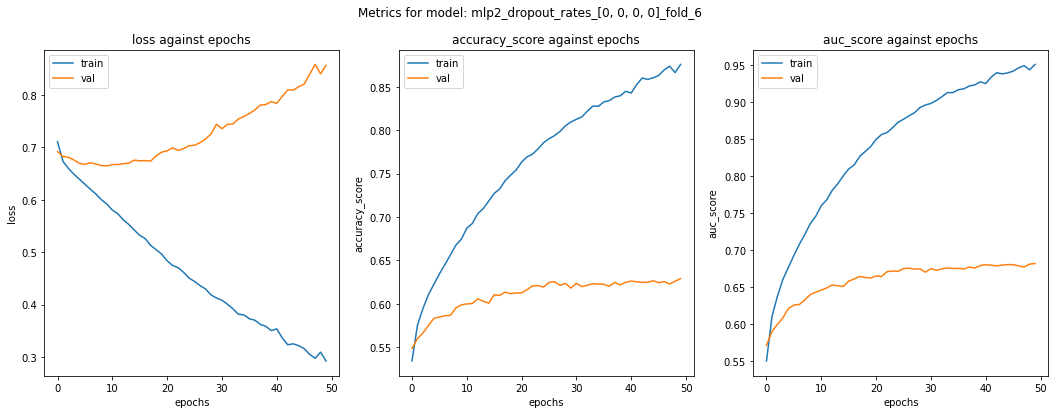

training model fold 7
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.7399 - accuracy: 0.5216 - auc: 0.5319 - val_loss: 0.6946 - val_accuracy: 0.5461 - val_auc: 0.5688
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.6761 - accuracy: 0.5731 - auc: 0.6056 - val_loss: 0.6815 - val_accuracy: 0.5581 - val_auc: 0.5899
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6616 - accuracy: 0.5945 - auc: 0.6346 - val_loss: 0.6786 - val_accuracy: 0.5664 - val_auc: 0.5995
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6501 - accuracy: 0.6093 - auc: 0.6577 - val_loss: 0.6751 - val_accuracy: 0.5736 - val_auc: 0.6086
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6423 - accuracy: 0.6207 - auc: 0.6725 - val_loss: 0.6703 - val_accuracy: 0.5797 - val_auc: 0.6196
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6302 - accuracy: 0.6348 - auc: 0

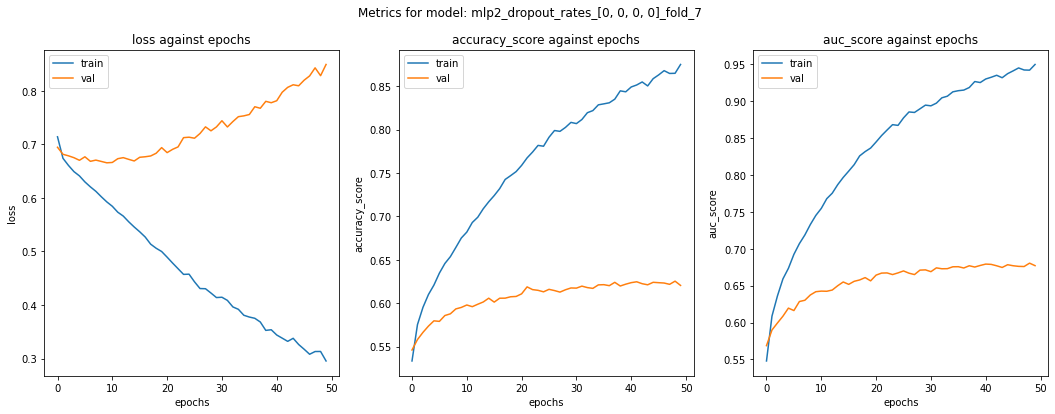

training model fold 8
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.7373 - accuracy: 0.5223 - auc: 0.5314 - val_loss: 0.6884 - val_accuracy: 0.5500 - val_auc: 0.5733
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6766 - accuracy: 0.5710 - auc: 0.6034 - val_loss: 0.6863 - val_accuracy: 0.5581 - val_auc: 0.5845
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6625 - accuracy: 0.5921 - auc: 0.6339 - val_loss: 0.6795 - val_accuracy: 0.5642 - val_auc: 0.5967
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6519 - accuracy: 0.6080 - auc: 0.6556 - val_loss: 0.6771 - val_accuracy: 0.5718 - val_auc: 0.6082
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6404 - accuracy: 0.6201 - auc: 0.6749 - val_loss: 0.6709 - val_accuracy: 0.5785 - val_auc: 0.6186
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6318 - accuracy: 0.6336 - auc: 0

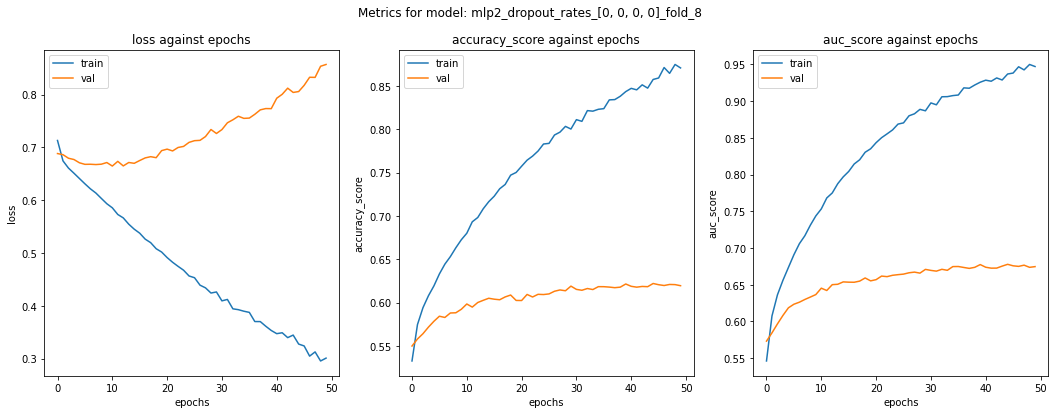

training model fold 9
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.7394 - accuracy: 0.5234 - auc: 0.5332 - val_loss: 0.6915 - val_accuracy: 0.5492 - val_auc: 0.5728
Epoch 2/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6751 - accuracy: 0.5732 - auc: 0.6071 - val_loss: 0.6834 - val_accuracy: 0.5615 - val_auc: 0.5912
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.6602 - accuracy: 0.5941 - auc: 0.6374 - val_loss: 0.6782 - val_accuracy: 0.5673 - val_auc: 0.6014
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.6496 - accuracy: 0.6102 - auc: 0.6587 - val_loss: 0.6740 - val_accuracy: 0.5721 - val_auc: 0.6105
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.6419 - accuracy: 0.6194 - auc: 0.6722 - val_loss: 0.6715 - val_accuracy: 0.5786 - val_auc: 0.6155
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6321 - accuracy: 0.6313 - auc: 0

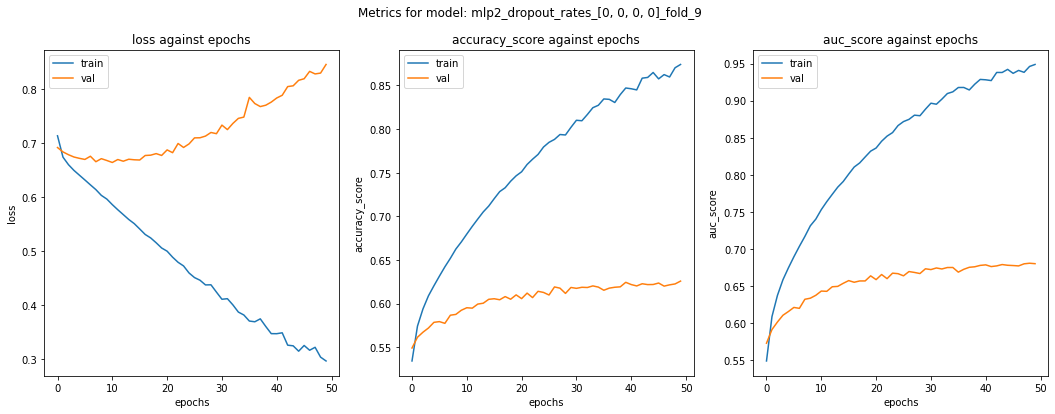

training model fold 10
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.7326 - accuracy: 0.5259 - auc: 0.5360 - val_loss: 0.6906 - val_accuracy: 0.5519 - val_auc: 0.5734
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.6737 - accuracy: 0.5744 - auc: 0.6093 - val_loss: 0.6832 - val_accuracy: 0.5626 - val_auc: 0.5927
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.6582 - accuracy: 0.5997 - auc: 0.6426 - val_loss: 0.6762 - val_accuracy: 0.5728 - val_auc: 0.6067
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.6499 - accuracy: 0.6094 - auc: 0.6579 - val_loss: 0.6729 - val_accuracy: 0.5753 - val_auc: 0.6129
Epoch 5/50
492/492 [==============================] - 3s 7ms/step - loss: 0.6411 - accuracy: 0.6205 - auc: 0.6741 - val_loss: 0.6743 - val_accuracy: 0.5788 - val_auc: 0.6150
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.6279 - accuracy: 0.6370 - auc: 

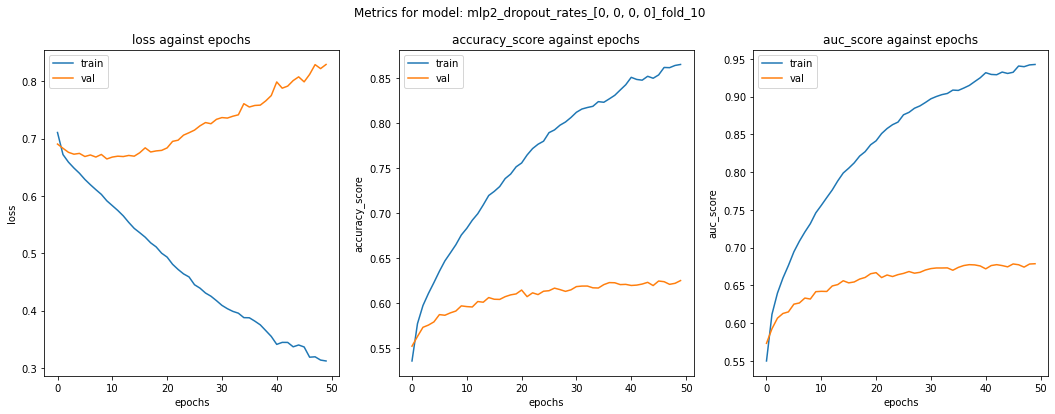

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1294.3104443258653, 0.622938404829027, 0.6228922680201341, 8904.8, 8495.8, 5184.4, 5348.1]
saved model metrics

model_name:  mlp2_dropout_rates_[0.2, 0.2, 0.2, 0.2]
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function relu at 0x7f7e9f836cb0>, dropout_rate=[0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8218 - accuracy: 0.5060 - auc: 0.5080 - val_loss: 0.6960 - val_accuracy: 0.5329 - val_auc: 0.5528
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7438 - accuracy: 0.5171 - auc: 0.5236 - val_loss: 0.6891 - val_accuracy: 0.5384 - val_auc: 0.5624
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7258 - accuracy: 0.5192 - auc: 0.5280 - val_loss: 0.6859 - val_accuracy: 0.5436 - val_auc: 0.5693
Epoch 4

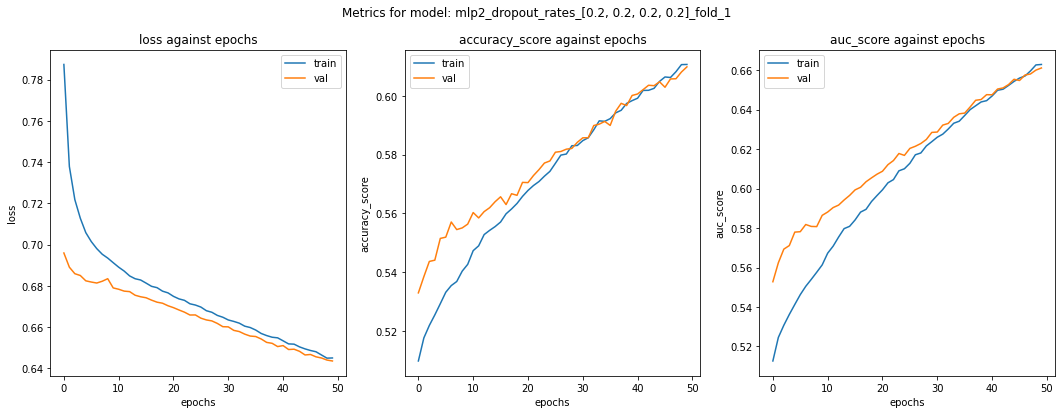

training model fold 2
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8212 - accuracy: 0.5046 - auc: 0.5076 - val_loss: 0.6995 - val_accuracy: 0.5315 - val_auc: 0.5436
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7405 - accuracy: 0.5178 - auc: 0.5254 - val_loss: 0.6888 - val_accuracy: 0.5421 - val_auc: 0.5605
Epoch 3/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7234 - accuracy: 0.5236 - auc: 0.5307 - val_loss: 0.6870 - val_accuracy: 0.5471 - val_auc: 0.5669
Epoch 4/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7142 - accuracy: 0.5265 - auc: 0.5366 - val_loss: 0.6846 - val_accuracy: 0.5469 - val_auc: 0.5720
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7083 - accuracy: 0.5308 - auc: 0.5418 - val_loss: 0.6846 - val_accuracy: 0.5467 - val_auc: 0.5728
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7045 - accuracy: 0.5298 - auc: 0

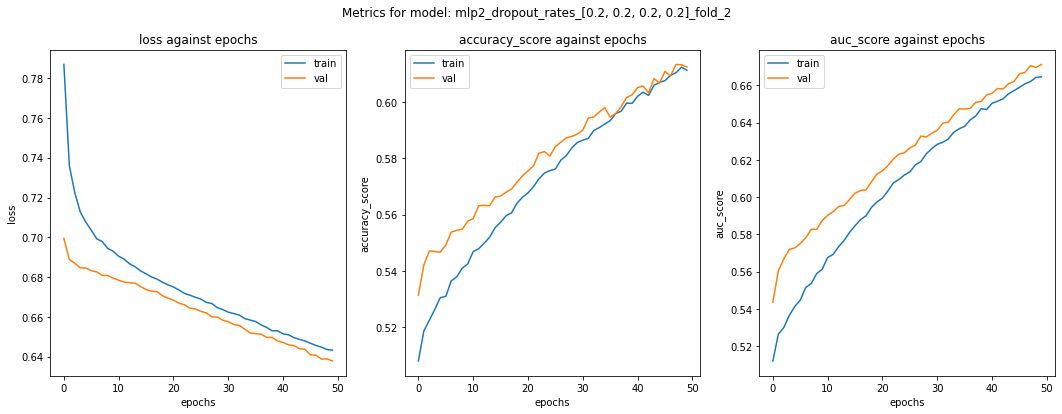

training model fold 3
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8229 - accuracy: 0.5040 - auc: 0.5062 - val_loss: 0.7002 - val_accuracy: 0.5292 - val_auc: 0.5445
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7433 - accuracy: 0.5167 - auc: 0.5239 - val_loss: 0.6910 - val_accuracy: 0.5395 - val_auc: 0.5579
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7229 - accuracy: 0.5228 - auc: 0.5329 - val_loss: 0.6887 - val_accuracy: 0.5408 - val_auc: 0.5615
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7140 - accuracy: 0.5262 - auc: 0.5358 - val_loss: 0.6863 - val_accuracy: 0.5478 - val_auc: 0.5674
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7054 - accuracy: 0.5299 - auc: 0.5435 - val_loss: 0.6858 - val_accuracy: 0.5462 - val_auc: 0.5712
Epoch 6/50
492/492 [==============================] - 3s 7ms/step - loss: 0.7025 - accuracy: 0.5322 - auc: 0

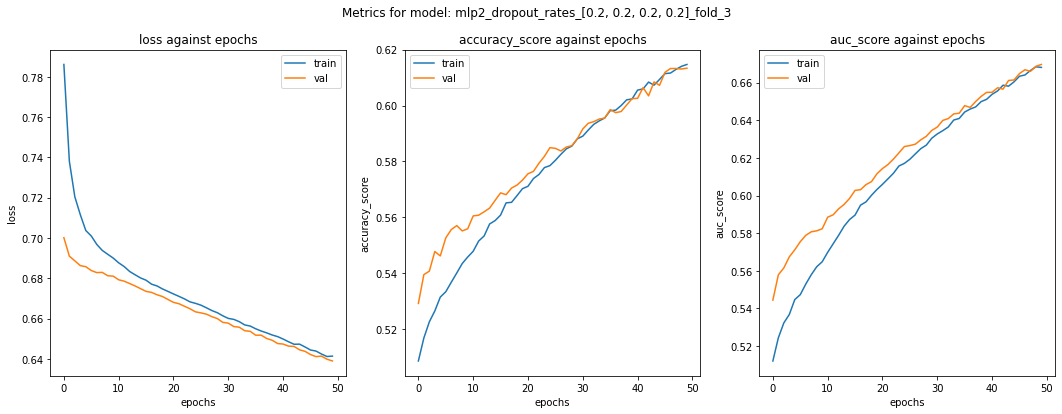

training model fold 4
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8221 - accuracy: 0.5057 - auc: 0.5073 - val_loss: 0.6992 - val_accuracy: 0.5315 - val_auc: 0.5468
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7437 - accuracy: 0.5183 - auc: 0.5242 - val_loss: 0.6861 - val_accuracy: 0.5488 - val_auc: 0.5679
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7252 - accuracy: 0.5217 - auc: 0.5292 - val_loss: 0.6882 - val_accuracy: 0.5489 - val_auc: 0.5700
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7155 - accuracy: 0.5249 - auc: 0.5345 - val_loss: 0.6832 - val_accuracy: 0.5529 - val_auc: 0.5781
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7067 - accuracy: 0.5318 - auc: 0.5433 - val_loss: 0.6823 - val_accuracy: 0.5559 - val_auc: 0.5824
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7034 - accuracy: 0.5320 - auc: 0

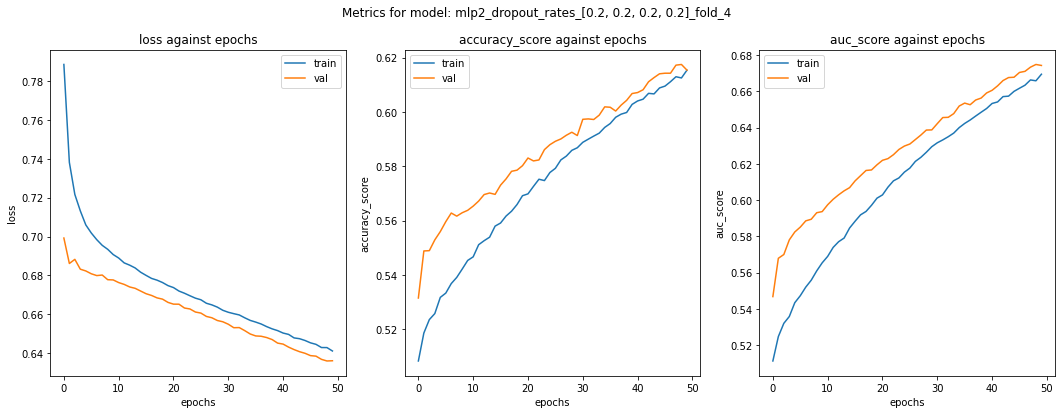

training model fold 5
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8180 - accuracy: 0.5066 - auc: 0.5111 - val_loss: 0.6963 - val_accuracy: 0.5351 - val_auc: 0.5508
Epoch 2/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7465 - accuracy: 0.5164 - auc: 0.5228 - val_loss: 0.6899 - val_accuracy: 0.5432 - val_auc: 0.5624
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7272 - accuracy: 0.5184 - auc: 0.5260 - val_loss: 0.6872 - val_accuracy: 0.5510 - val_auc: 0.5700
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7154 - accuracy: 0.5273 - auc: 0.5363 - val_loss: 0.6839 - val_accuracy: 0.5499 - val_auc: 0.5740
Epoch 5/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7075 - accuracy: 0.5307 - auc: 0.5421 - val_loss: 0.6842 - val_accuracy: 0.5494 - val_auc: 0.5749
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7039 - accuracy: 0.5337 - auc: 0

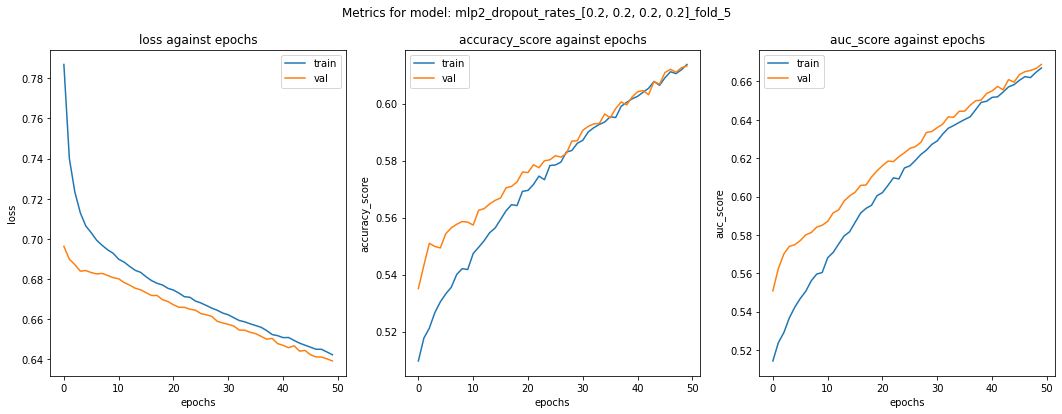

training model fold 6
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.8109 - accuracy: 0.5072 - auc: 0.5100 - val_loss: 0.6966 - val_accuracy: 0.5301 - val_auc: 0.5423
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7412 - accuracy: 0.5156 - auc: 0.5200 - val_loss: 0.6890 - val_accuracy: 0.5440 - val_auc: 0.5599
Epoch 3/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7226 - accuracy: 0.5197 - auc: 0.5290 - val_loss: 0.6899 - val_accuracy: 0.5424 - val_auc: 0.5624
Epoch 4/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7134 - accuracy: 0.5246 - auc: 0.5347 - val_loss: 0.6852 - val_accuracy: 0.5443 - val_auc: 0.5665
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7061 - accuracy: 0.5284 - auc: 0.5415 - val_loss: 0.6824 - val_accuracy: 0.5511 - val_auc: 0.5765
Epoch 6/50
492/492 [==============================] - 4s 7ms/step - loss: 0.7020 - accuracy: 0.5325 - auc: 0

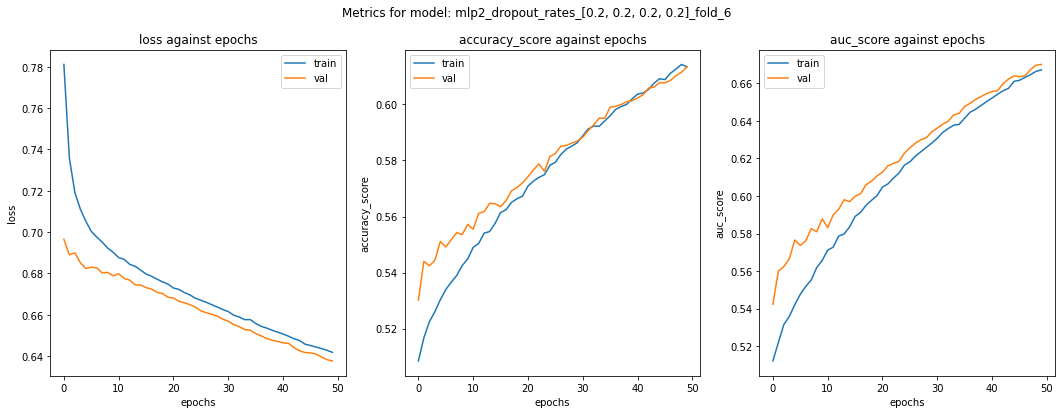

training model fold 7
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8134 - accuracy: 0.5074 - auc: 0.5093 - val_loss: 0.6970 - val_accuracy: 0.5287 - val_auc: 0.5468
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7406 - accuracy: 0.5181 - auc: 0.5270 - val_loss: 0.6911 - val_accuracy: 0.5335 - val_auc: 0.5572
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7217 - accuracy: 0.5237 - auc: 0.5332 - val_loss: 0.6870 - val_accuracy: 0.5440 - val_auc: 0.5641
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7135 - accuracy: 0.5244 - auc: 0.5335 - val_loss: 0.6852 - val_accuracy: 0.5465 - val_auc: 0.5660
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7065 - accuracy: 0.5272 - auc: 0.5403 - val_loss: 0.6844 - val_accuracy: 0.5459 - val_auc: 0.5707
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7009 - accuracy: 0.5340 - auc: 0

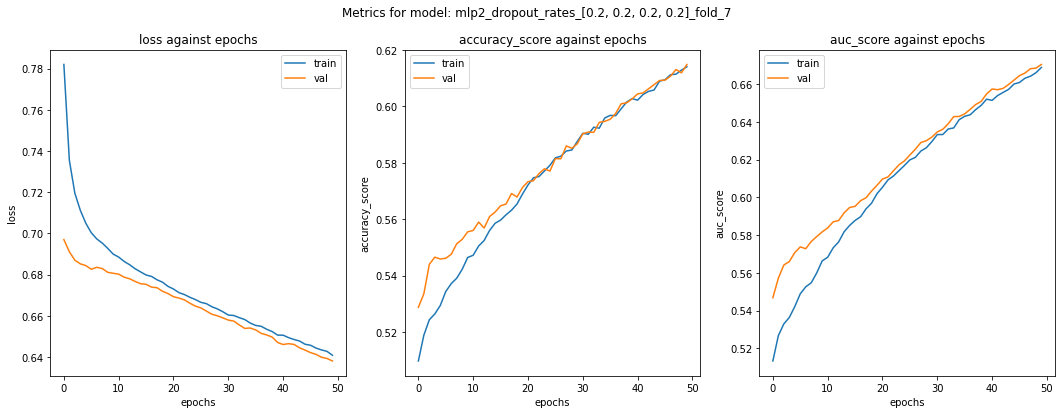

training model fold 8
Epoch 1/50
492/492 [==============================] - 6s 8ms/step - loss: 0.8145 - accuracy: 0.5074 - auc: 0.5104 - val_loss: 0.6941 - val_accuracy: 0.5411 - val_auc: 0.5558
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7414 - accuracy: 0.5191 - auc: 0.5265 - val_loss: 0.6873 - val_accuracy: 0.5466 - val_auc: 0.5647
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7224 - accuracy: 0.5219 - auc: 0.5327 - val_loss: 0.6841 - val_accuracy: 0.5517 - val_auc: 0.5731
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7118 - accuracy: 0.5268 - auc: 0.5383 - val_loss: 0.6835 - val_accuracy: 0.5499 - val_auc: 0.5752
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7048 - accuracy: 0.5306 - auc: 0.5447 - val_loss: 0.6829 - val_accuracy: 0.5550 - val_auc: 0.5795
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7023 - accuracy: 0.5331 - auc: 0

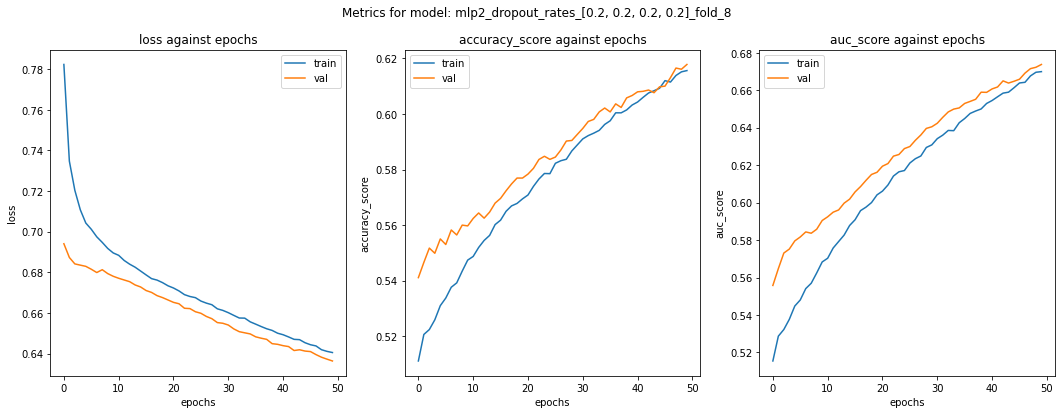

training model fold 9
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8140 - accuracy: 0.5095 - auc: 0.5119 - val_loss: 0.6956 - val_accuracy: 0.5330 - val_auc: 0.5509
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7433 - accuracy: 0.5169 - auc: 0.5234 - val_loss: 0.6897 - val_accuracy: 0.5393 - val_auc: 0.5598
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7247 - accuracy: 0.5204 - auc: 0.5291 - val_loss: 0.6880 - val_accuracy: 0.5428 - val_auc: 0.5650
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7136 - accuracy: 0.5258 - auc: 0.5365 - val_loss: 0.6852 - val_accuracy: 0.5470 - val_auc: 0.5712
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7068 - accuracy: 0.5290 - auc: 0.5418 - val_loss: 0.6846 - val_accuracy: 0.5497 - val_auc: 0.5750
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7031 - accuracy: 0.5327 - auc: 0

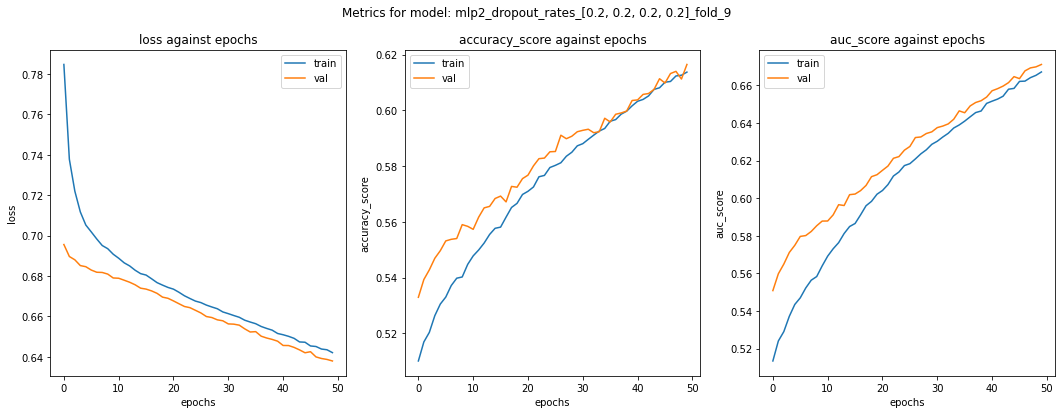

training model fold 10
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8080 - accuracy: 0.5074 - auc: 0.5096 - val_loss: 0.6940 - val_accuracy: 0.5349 - val_auc: 0.5462
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7384 - accuracy: 0.5149 - auc: 0.5206 - val_loss: 0.6902 - val_accuracy: 0.5400 - val_auc: 0.5568
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7203 - accuracy: 0.5215 - auc: 0.5299 - val_loss: 0.6866 - val_accuracy: 0.5438 - val_auc: 0.5652
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7122 - accuracy: 0.5258 - auc: 0.5347 - val_loss: 0.6852 - val_accuracy: 0.5467 - val_auc: 0.5679
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7050 - accuracy: 0.5284 - auc: 0.5402 - val_loss: 0.6840 - val_accuracy: 0.5502 - val_auc: 0.5726
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7009 - accuracy: 0.5343 - auc: 

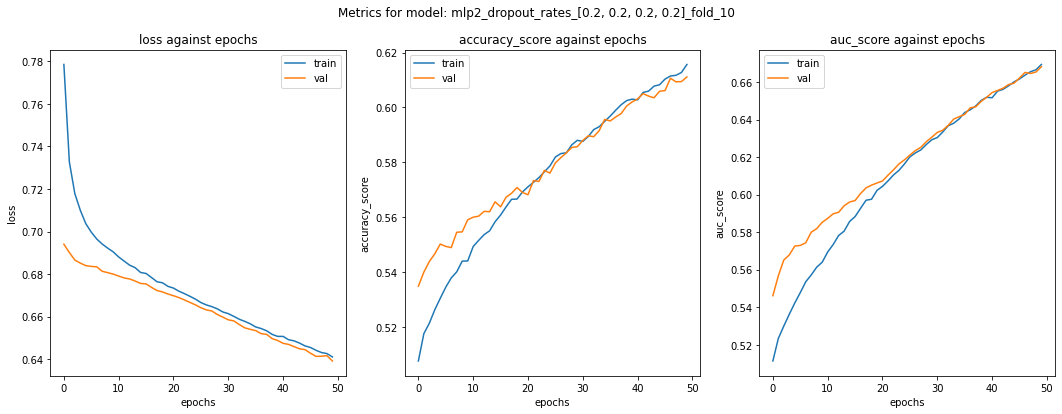

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1246.4106461224906, 0.6138022772279682, 0.613363975150499, 9058.9, 8086.5, 5593.7, 5194.0]
saved model metrics

model_name:  mlp2_dropout_rates_[0.3, 0.4, 0.4, 0.4]
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function relu at 0x7f7e9f836cb0>, dropout_rate=[0.3, 0.4, 0.4, 0.4], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8655 - accuracy: 0.5043 - auc: 0.5056 - val_loss: 0.6961 - val_accuracy: 0.5291 - val_auc: 0.5451
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7730 - accuracy: 0.5074 - auc: 0.5092 - val_loss: 0.6927 - val_accuracy: 0.5276 - val_auc: 0.5517
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7415 - accuracy: 0.5064 - auc: 0.5096 - val_loss: 0.6890 - val_accuracy: 0.5330 - val_auc: 0.5558
Epoch 4

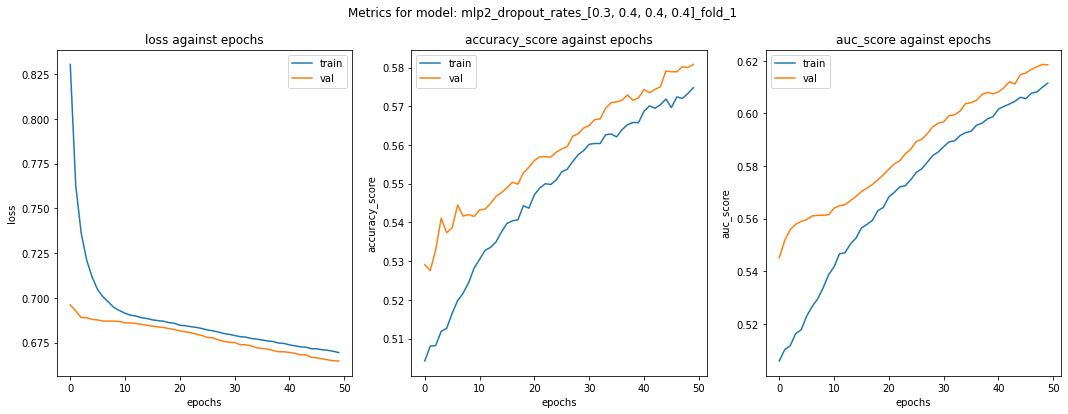

training model fold 2
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8792 - accuracy: 0.5038 - auc: 0.5040 - val_loss: 0.6954 - val_accuracy: 0.5225 - val_auc: 0.5321
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7798 - accuracy: 0.5059 - auc: 0.5080 - val_loss: 0.6922 - val_accuracy: 0.5284 - val_auc: 0.5407
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7467 - accuracy: 0.5068 - auc: 0.5081 - val_loss: 0.6903 - val_accuracy: 0.5340 - val_auc: 0.5474
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7277 - accuracy: 0.5097 - auc: 0.5113 - val_loss: 0.6894 - val_accuracy: 0.5315 - val_auc: 0.5489
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7165 - accuracy: 0.5131 - auc: 0.5167 - val_loss: 0.6890 - val_accuracy: 0.5363 - val_auc: 0.5526
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7082 - accuracy: 0.5171 - auc: 0

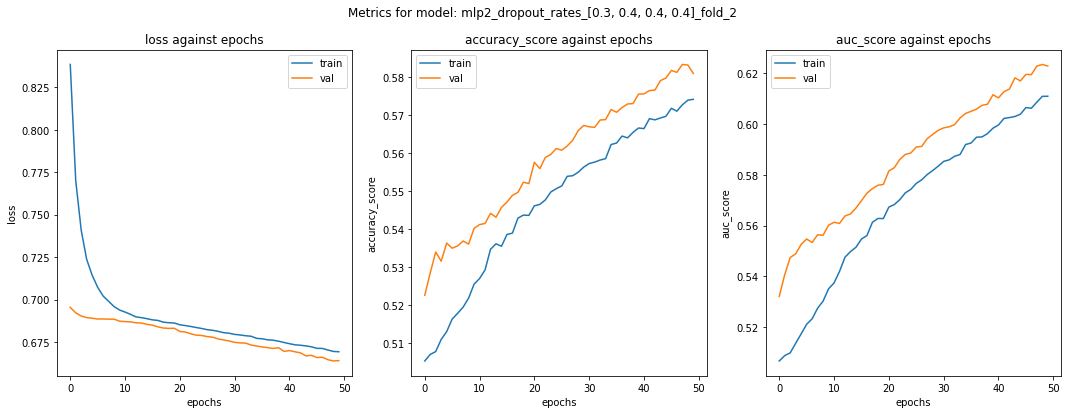

training model fold 3
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8880 - accuracy: 0.5042 - auc: 0.5046 - val_loss: 0.6985 - val_accuracy: 0.5219 - val_auc: 0.5343
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7868 - accuracy: 0.5054 - auc: 0.5084 - val_loss: 0.6950 - val_accuracy: 0.5243 - val_auc: 0.5403
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7512 - accuracy: 0.5079 - auc: 0.5110 - val_loss: 0.6933 - val_accuracy: 0.5297 - val_auc: 0.5435
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7330 - accuracy: 0.5099 - auc: 0.5136 - val_loss: 0.6905 - val_accuracy: 0.5262 - val_auc: 0.5469
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7189 - accuracy: 0.5106 - auc: 0.5154 - val_loss: 0.6897 - val_accuracy: 0.5281 - val_auc: 0.5481
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7112 - accuracy: 0.5150 - auc: 0

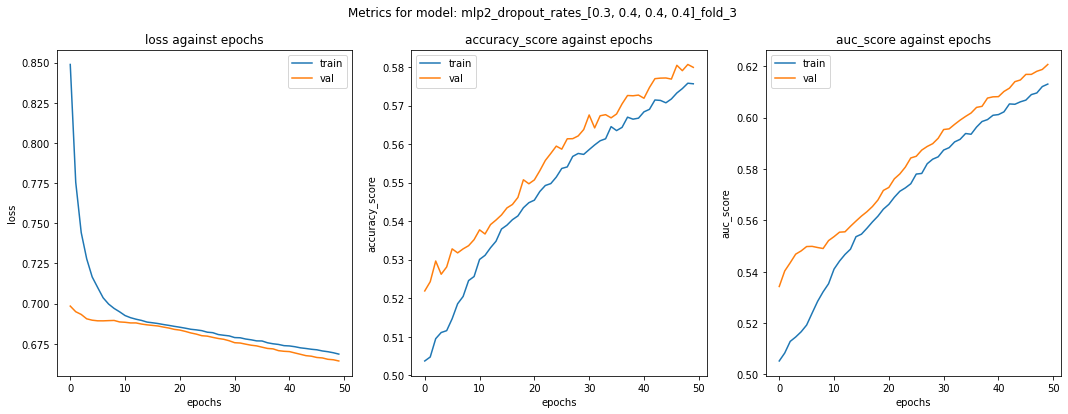

training model fold 4
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8787 - accuracy: 0.5035 - auc: 0.5044 - val_loss: 0.6994 - val_accuracy: 0.5251 - val_auc: 0.5365
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7821 - accuracy: 0.5078 - auc: 0.5100 - val_loss: 0.6919 - val_accuracy: 0.5270 - val_auc: 0.5507
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7479 - accuracy: 0.5090 - auc: 0.5120 - val_loss: 0.6903 - val_accuracy: 0.5284 - val_auc: 0.5533
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7285 - accuracy: 0.5115 - auc: 0.5146 - val_loss: 0.6884 - val_accuracy: 0.5383 - val_auc: 0.5550
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7149 - accuracy: 0.5158 - auc: 0.5219 - val_loss: 0.6877 - val_accuracy: 0.5369 - val_auc: 0.5562
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7087 - accuracy: 0.5137 - auc: 0

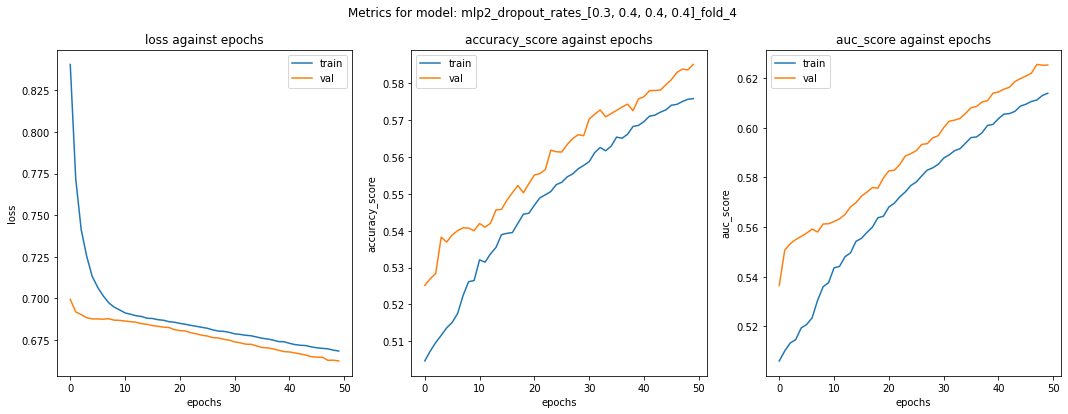

training model fold 5
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8851 - accuracy: 0.5028 - auc: 0.5036 - val_loss: 0.6976 - val_accuracy: 0.5187 - val_auc: 0.5371
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7834 - accuracy: 0.5078 - auc: 0.5100 - val_loss: 0.6912 - val_accuracy: 0.5365 - val_auc: 0.5491
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7502 - accuracy: 0.5079 - auc: 0.5107 - val_loss: 0.6903 - val_accuracy: 0.5326 - val_auc: 0.5506
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7277 - accuracy: 0.5125 - auc: 0.5169 - val_loss: 0.6895 - val_accuracy: 0.5333 - val_auc: 0.5498
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7193 - accuracy: 0.5124 - auc: 0.5158 - val_loss: 0.6888 - val_accuracy: 0.5357 - val_auc: 0.5519
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7092 - accuracy: 0.5164 - auc: 0

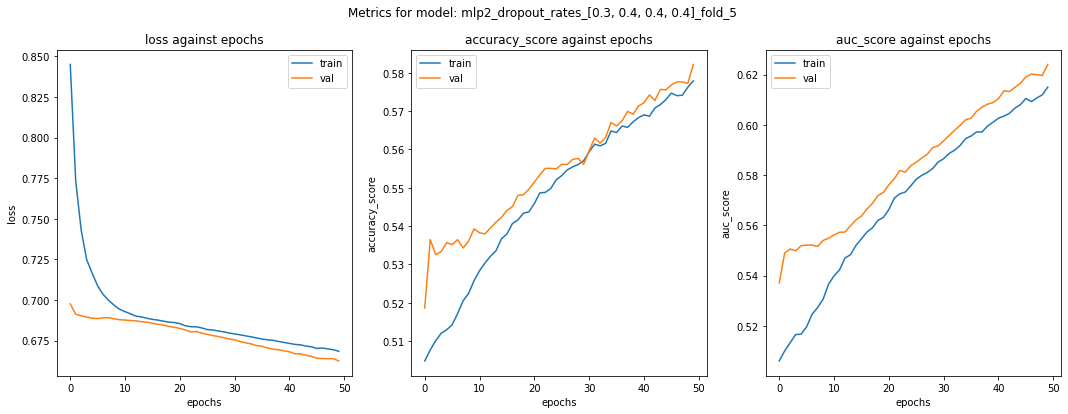

training model fold 6
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8838 - accuracy: 0.4997 - auc: 0.5006 - val_loss: 0.6977 - val_accuracy: 0.5172 - val_auc: 0.5343
Epoch 2/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7819 - accuracy: 0.5069 - auc: 0.5082 - val_loss: 0.6916 - val_accuracy: 0.5264 - val_auc: 0.5450
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7486 - accuracy: 0.5054 - auc: 0.5070 - val_loss: 0.6928 - val_accuracy: 0.5250 - val_auc: 0.5429
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7274 - accuracy: 0.5122 - auc: 0.5171 - val_loss: 0.6891 - val_accuracy: 0.5350 - val_auc: 0.5504
Epoch 5/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7178 - accuracy: 0.5118 - auc: 0.5165 - val_loss: 0.6893 - val_accuracy: 0.5336 - val_auc: 0.5493
Epoch 6/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7092 - accuracy: 0.5154 - auc: 0

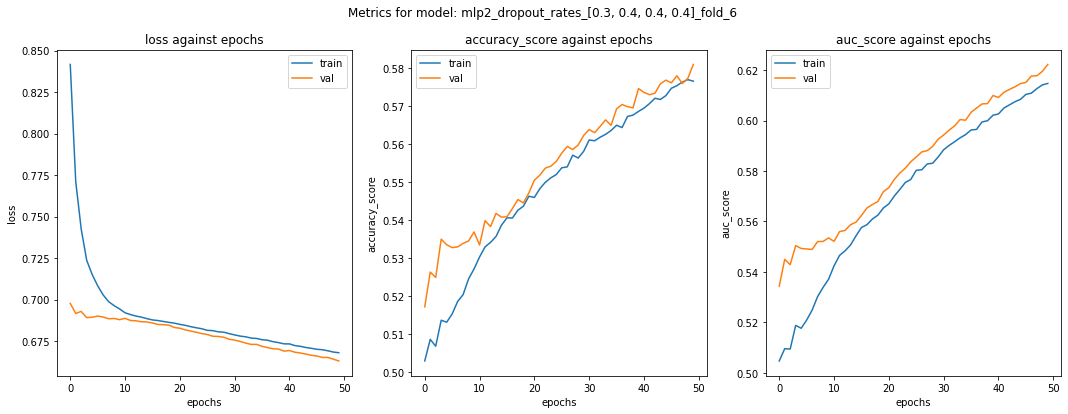

training model fold 7
Epoch 1/50
492/492 [==============================] - 6s 10ms/step - loss: 0.8794 - accuracy: 0.5026 - auc: 0.5037 - val_loss: 0.7007 - val_accuracy: 0.5182 - val_auc: 0.5313
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7797 - accuracy: 0.5068 - auc: 0.5105 - val_loss: 0.6972 - val_accuracy: 0.5199 - val_auc: 0.5370
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7470 - accuracy: 0.5085 - auc: 0.5120 - val_loss: 0.6911 - val_accuracy: 0.5218 - val_auc: 0.5440
Epoch 4/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7312 - accuracy: 0.5091 - auc: 0.5133 - val_loss: 0.6899 - val_accuracy: 0.5243 - val_auc: 0.5468
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7182 - accuracy: 0.5133 - auc: 0.5173 - val_loss: 0.6892 - val_accuracy: 0.5348 - val_auc: 0.5483
Epoch 6/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7103 - accuracy: 0.5162 - auc: 

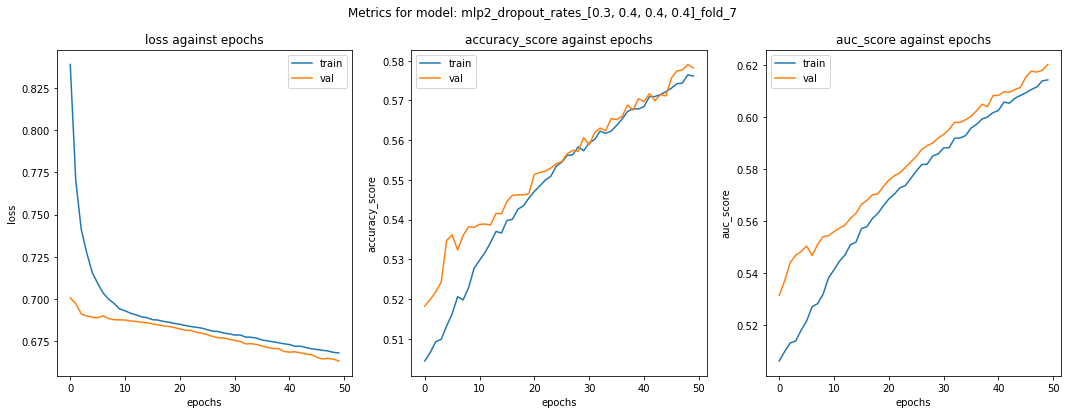

training model fold 8
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8929 - accuracy: 0.5015 - auc: 0.5033 - val_loss: 0.6973 - val_accuracy: 0.5222 - val_auc: 0.5343
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7900 - accuracy: 0.5054 - auc: 0.5068 - val_loss: 0.6931 - val_accuracy: 0.5294 - val_auc: 0.5419
Epoch 3/50
492/492 [==============================] - 4s 8ms/step - loss: 0.7510 - accuracy: 0.5076 - auc: 0.5120 - val_loss: 0.6895 - val_accuracy: 0.5292 - val_auc: 0.5486
Epoch 4/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7301 - accuracy: 0.5121 - auc: 0.5139 - val_loss: 0.6889 - val_accuracy: 0.5384 - val_auc: 0.5516
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7209 - accuracy: 0.5110 - auc: 0.5147 - val_loss: 0.6891 - val_accuracy: 0.5409 - val_auc: 0.5534
Epoch 6/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7098 - accuracy: 0.5163 - auc: 0

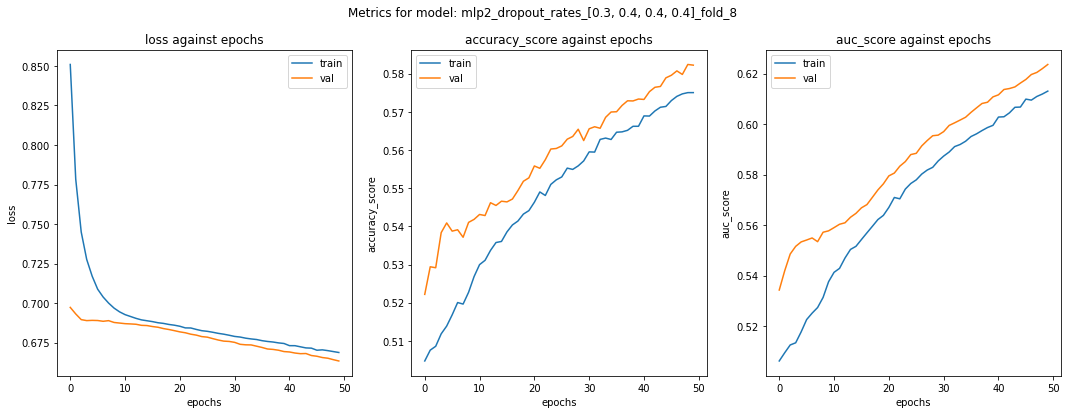

training model fold 9
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8813 - accuracy: 0.5031 - auc: 0.5038 - val_loss: 0.6949 - val_accuracy: 0.5240 - val_auc: 0.5364
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7782 - accuracy: 0.5077 - auc: 0.5102 - val_loss: 0.6907 - val_accuracy: 0.5280 - val_auc: 0.5439
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7454 - accuracy: 0.5085 - auc: 0.5125 - val_loss: 0.6899 - val_accuracy: 0.5311 - val_auc: 0.5470
Epoch 4/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7285 - accuracy: 0.5096 - auc: 0.5135 - val_loss: 0.6891 - val_accuracy: 0.5341 - val_auc: 0.5502
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7159 - accuracy: 0.5117 - auc: 0.5173 - val_loss: 0.6888 - val_accuracy: 0.5354 - val_auc: 0.5521
Epoch 6/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7087 - accuracy: 0.5173 - auc: 0

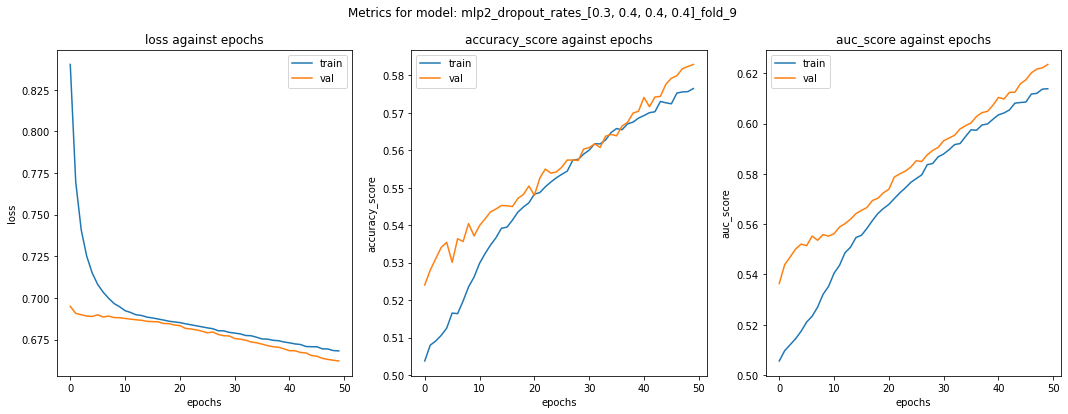

training model fold 10
Epoch 1/50
492/492 [==============================] - 6s 9ms/step - loss: 0.8867 - accuracy: 0.5017 - auc: 0.5029 - val_loss: 0.6950 - val_accuracy: 0.5246 - val_auc: 0.5326
Epoch 2/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7858 - accuracy: 0.5043 - auc: 0.5074 - val_loss: 0.6922 - val_accuracy: 0.5307 - val_auc: 0.5425
Epoch 3/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7495 - accuracy: 0.5080 - auc: 0.5112 - val_loss: 0.6905 - val_accuracy: 0.5302 - val_auc: 0.5455
Epoch 4/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7312 - accuracy: 0.5112 - auc: 0.5143 - val_loss: 0.6907 - val_accuracy: 0.5323 - val_auc: 0.5470
Epoch 5/50
492/492 [==============================] - 4s 9ms/step - loss: 0.7202 - accuracy: 0.5098 - auc: 0.5148 - val_loss: 0.6894 - val_accuracy: 0.5354 - val_auc: 0.5500
Epoch 6/50
492/492 [==============================] - 5s 9ms/step - loss: 0.7113 - accuracy: 0.5148 - auc: 

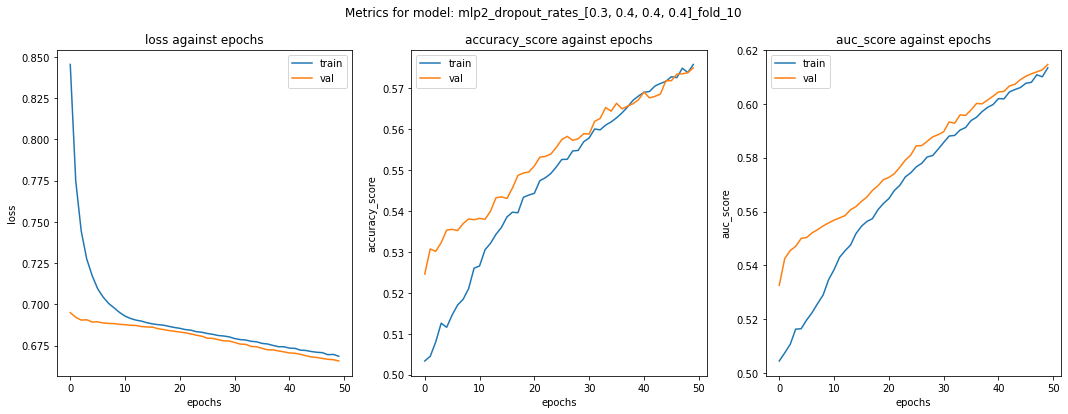

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [859.7642387656146, 0.5808413675666977, 0.5803159568272035, 8634.6, 7590.1, 6090.1, 5618.3]
saved model metrics


In [ ]:
for batch_size in batch_sizes:
  for hidden_unit in hidden_units:
    for activation in activations:
      for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
          for epoch in epochs:

            output_filename = "CV_SCORES_AVE_NNDL.csv"
            workbook_name = "12D_nndl_cv_mlp2_dropout_rates"
            model_name = f"mlp2_dropout_rates_{dropout_rate}"
            model_params = f"batch_size={batch_size}, hidden_unit={hidden_unit}, activation={activation}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, epoch={epoch}"
                    
            print("")
            print("model_name: ", model_name)
            print("model_params: ", model_params)

            # cross validation
            cv_scores = []

            for i, (train_idx, val_idx) in enumerate(kf.split(x_train)):
              # train-val data (for utility score calculation) 
              train_cv, val_cv = train.iloc[train_idx], train.iloc[val_idx]
              # train-val features 
              x_train_cv, x_val_cv, y_train_cv, y_val_cv = x_train[train_idx], x_train[val_idx], y_train[train_idx], y_train[val_idx]

              # scaling data to make it easier for models to train
              scaler = StandardScaler().fit(x_train_cv)
              x_train_cv = scaler.transform(x_train_cv)

              # test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
              x_val_cv = scaler.transform(x_val_cv)

              print(f"training model fold {i+1}")

              model = create_mlp(x_train_cv.shape[1], hidden_unit, activation, dropout_rate, learning_rate)
              model_name_fold = model_name + f"_fold_{i+1}"
              # CheckpointCallback = ModelCheckpoint(str(PATH_CHECKPOINTS / (model_name + '.hdf5')), monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', save_freq='epoch')

              history = model.fit(
                  x_train_cv, 
                  y_train_cv, 
                  epochs=epoch, 
                  batch_size=batch_size,
                  validation_data=(x_val_cv, y_val_cv),
                  # callbacks = [CheckpointCallback]
              )

              model_score = model_scores(model, test=val_cv, x_test=x_val_cv, y_test=y_val_cv)
              cv_scores.append(model_score)

              history_saver(history, model_name_fold, PATH_HISTORIES, already_npy=False)
              history = history_loader(model_name_fold, PATH_HISTORIES)
              plot_metrics(history, model_name_fold, PATH_FIGURES)

            # mean of cv scores
            cv_scores_ave = [sum(ele) / len(cv_scores) for ele in zip(*cv_scores)]
            print("cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg")
            print("cv_scores_ave: ", cv_scores_ave)

            # save average scores
            save_scores(output_filename, workbook_name, model_name, model_params, *cv_scores_ave)


In [ ]:
# '''
# predict on the test set. load best weights from checkpoints
# '''
# # model.load_weights(str(PATH_CHECKPOINTS / (model_name + '.hdf5')))

# test_metrics = model.evaluate(x_test, steps=3)

# test_metrics_dict = {
#     'test_loss': test_metrics[0]
# }

# np.save(PATH_PREDICTIONS/str(model_name + "_prediction_score"), test_metrics_dict)

In [ ]:
# y_pred = (model.predict(x_test) > 0.5).astype(int)
# utility_score(test, y_pred)

# Conclusion